In [2]:
from ipynb.fs.full.DataFormatting import *
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from pyspark.ml.fpm import PrefixSpan
from pyspark.shell import sc
from pyspark.sql.functions import desc
from pyspark.sql.types import Row
import matplotlib.pyplot as plt


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022 16:36:42)
Spark context Web UI available at http://10.0.13.166:4041
Spark context available as 'sc' (master = local[*], app id = local-1667128761092).
SparkSession available as 'spark'.


## Identifying patterns between different student recipes

### Pattern Mining 
There are a total of 187 students. What we would like to do is either some pattern mining for each student and their recipes to better understand each users writing. 
First of all, we will define a pattern mining algorithm, called ```PrefixSpan```. It enumerates frequent sequential patterns from a set of sequences. For now we only define the function.

A word about ```PrefixSpan```

Parameters: 
* Minimum Support (```minSupport```) : support is calculated as the % of sequences containing the subsequence
* Maximum Subsequence Length (```maxPatternLength```) : speaks for itself

If ```minSupport``` is little and ```maxPatternLength``` is large, the running time of ```PrefixSpan``` gets exceedingly long. The contrary gives reasonable running time but some subsequences can be left undiscovered.



In [3]:
def apply_prefixSpan(data, minSupport=0.2, maxPatternLength=8, kind='barh', title=""):
    """
    input an array of indices on which you want to apply prefix span. So for example, we want to apply it to the first 
    thing users write so we input the indices of the first text they write in ...
    indices = list[int] -> the indices of the data we want to look at
    data = list[list[obj]] -> list of sentences ie list of lists of words
    """
    range_ = range(len(data))
    #map to rows so that
    for i in range_:
        data[i] = Row(sequence=[data[i]])

    l = [data[i] for i in range_]

    DF = sc.parallelize(l).toDF()

    prefixSpan = PrefixSpan(minSupport=minSupport, maxPatternLength=maxPatternLength, maxLocalProjDBSize=32000000)

    # Find frequent sequential patterns.
    find_pat = prefixSpan.findFrequentSequentialPatterns(DF).sort(desc('freq')).collect()

    NUM_PATTERNS_TO_PLOT = 25
    df2 = pd.DataFrame(list(map(lambda _: _.asDict(), find_pat[:NUM_PATTERNS_TO_PLOT])))
    df2.plot(kind=kind,x='sequence', y='freq', figsize=(6, 9), title=title)
    return find_pat

Now that we defined the algorithm using ```pyspark```, we will do the following:
* First, count the most common words users write the first time they use the platform
    * That means we take the first thing users wrote on the platform - before getting any suggestions from the system (if they have any)!
* Then we apply `PrefixSpan` on the sequence of words they wrote to see if there are any correlations between texts. However, the algorithm finds sequential patterns so the result isn't very satisfying (Find other algo?)

We start by defining a function that counts the most occuring words in data, without punctuation and stop words.

In [4]:
def flatten_and_filter_strings(ls):
    flat_list = [elem for sublist in ls for elem in sublist if elem not in noisy_punct and elem not in stop_words]
    return flat_list
    
def count_and_plot_most_common_words(data):
    """
    count the occurence of each word in data
    data: list[str]
    """
    c = Counter(data)
    dframe = pd.DataFrame(c.most_common(30), columns=['words', 'occurences'])
    dframe.plot(kind='barh', x='words', y='occurences', figsize=(10,7))

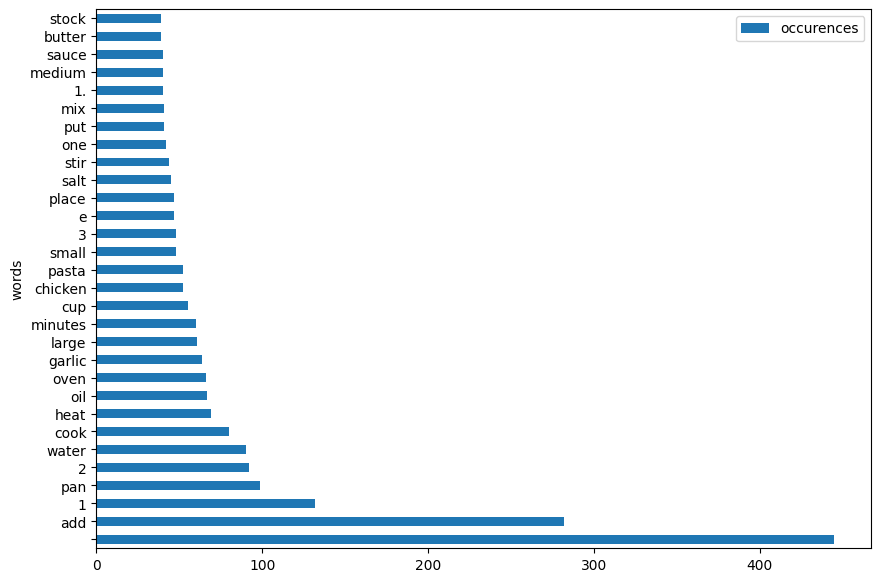

In [5]:
indices_of_first_attempts_per_user = df.groupby('user_id').head(1).index

data = pd.read_json('data/new_data.json')
stop_words = set(stopwords.words('english'))
def filter_from_arrays(word):
    return word not in KEYWORDS and word not in stop_words and word not in noisy_punct

first_attempt_at_recipe_per_student = [list(map(lambda _: _['word'], filter(lambda _ : _ is not None, data[i]))) for i in indices_of_first_attempts_per_user]
#we filter the words we got from words in keywords, or stop words (like "the", "and"...) as well as punctuation
first_attempt_at_recipe_per_student = [list(filter(lambda _ : filter_from_arrays(_), first_attempt_at_recipe_per_student[i])) for i in range(len(indices_of_first_attempts_per_user))]

count_and_plot_most_common_words(flatten_and_filter_strings(first_attempt_at_recipe_per_student))
#apply_prefixSpan(data=first_attempt_at_recipe_per_student, title="Prefix Span on the first content each user wrote")

Now, we do the same thing but for the final recipe every user submits (so now we don't get the last recipe they submit from the keystrokes but from the 'recipe' column)

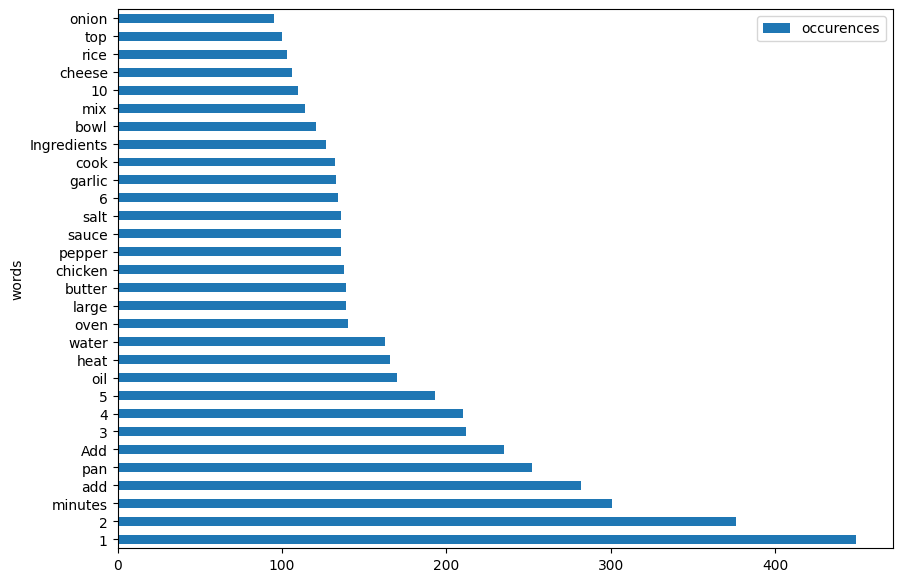

In [6]:
last_submitted_recipe_per_user = list(map(lambda index: index - 1, indices_of_first_attempts_per_user))[1:]
#we take the index of where the users first write and at the index i - 1 it is the index where the previous user last wrote!!
#and we do [1:] because where the first user first wrote is index 0, and 0 - 1 is out of bounds
recipes_submitted = [word_tokenize(df['recipe'].iloc[i]) for i in last_submitted_recipe_per_user]
recipes_submitted = [list(filter(lambda word: word not in stop_words and word not in noisy_punct, recipes_submitted[i])) for i in range(len(recipes_submitted))]
count_and_plot_most_common_words(flatten_and_filter_strings(recipes_submitted))
#apply_prefixSpan(data=recipes_submitted, minSupport=0.6,title="Prefix Span applied on the final recipe users submitted")

We can kind of argue that the ML model suggests users to enumerate what they write and the order of the steps - also confirmed by the most common words 